In [149]:
import numpy as np
import soundfile as sr

speech1 = sr.read('resources/speech1.wav')
speech2 = sr.read('resources/speech2.wav')

In [150]:
speech1[0].shape

(45466,)

In [151]:
speech2[0].shape[0]

45773

In [152]:
print(f'The sampling rate of speech1 is: {speech1[1]}Hz')
print(f'The sampling rate of speech2 is: {speech2[1]}Hz')

The sampling rate of speech1 is: 16000Hz
The sampling rate of speech2 is: 16000Hz


In [153]:
import matplotlib.pyplot as plt

sample_rate = speech1[1]

num_samples1 = speech1[0].shape[0]
num_samples2 = speech2[0].shape[0]
speech1_data = speech1[0]
speech2_data = speech2[0]

x1 = np.linspace(0, num_samples1, num=num_samples1, dtype=np.int32)
x2 = np.linspace(0, num_samples2, num=num_samples2, dtype=np.int32)

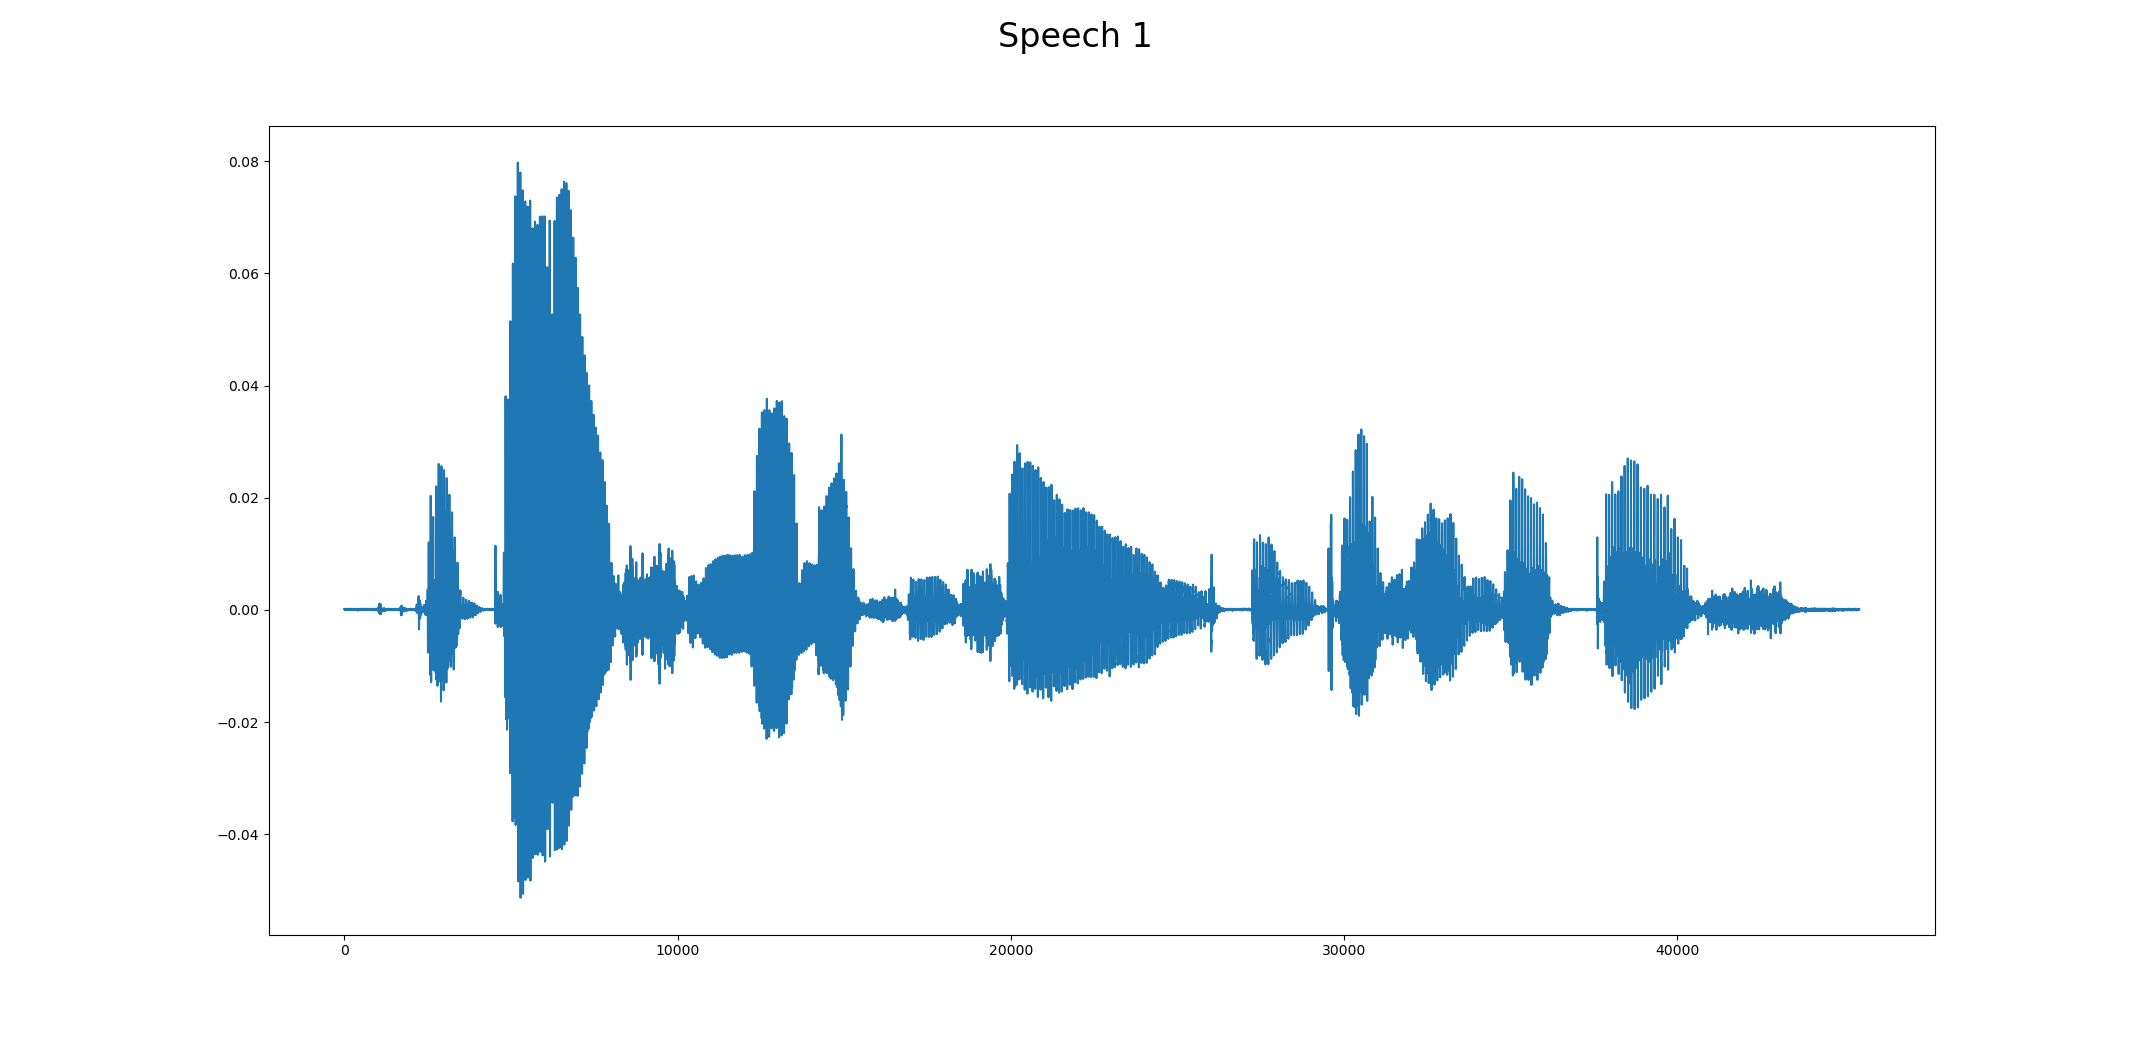

In [154]:
%matplotlib widget
fig = plt.gcf()
fig.set_size_inches(21.5, 10.5)
plt.suptitle("Speech 1", fontsize=24)
plt.plot(x1, speech1_data)

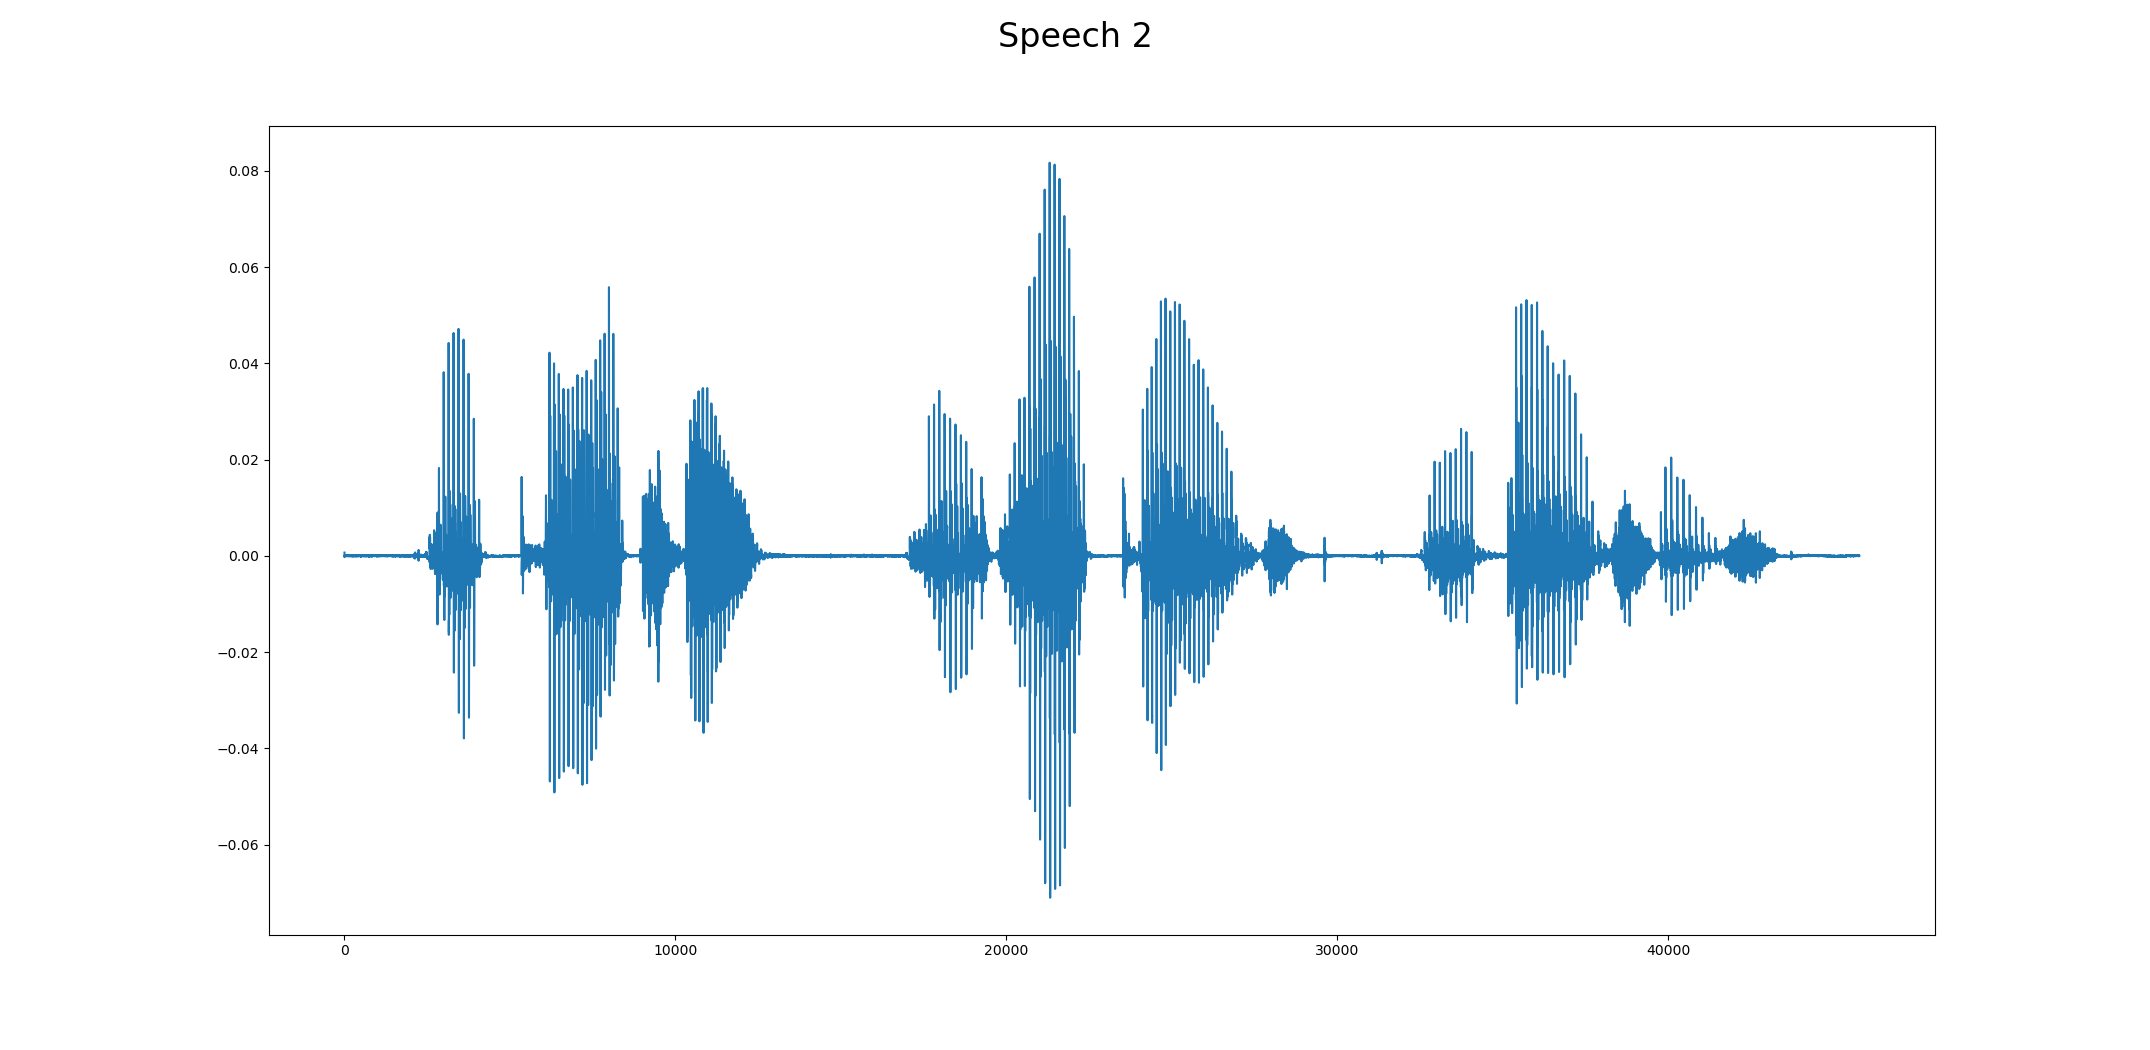

In [155]:
%matplotlib widget
fig = plt.gcf()
fig.set_size_inches(21.5, 10.5)
plt.suptitle("Speech 2", fontsize=24)
plt.plot(x2, speech2_data)

In [156]:
np.argmax(speech1_data)

5203

In [157]:
np.max(speech1_data)

0.0797119140625

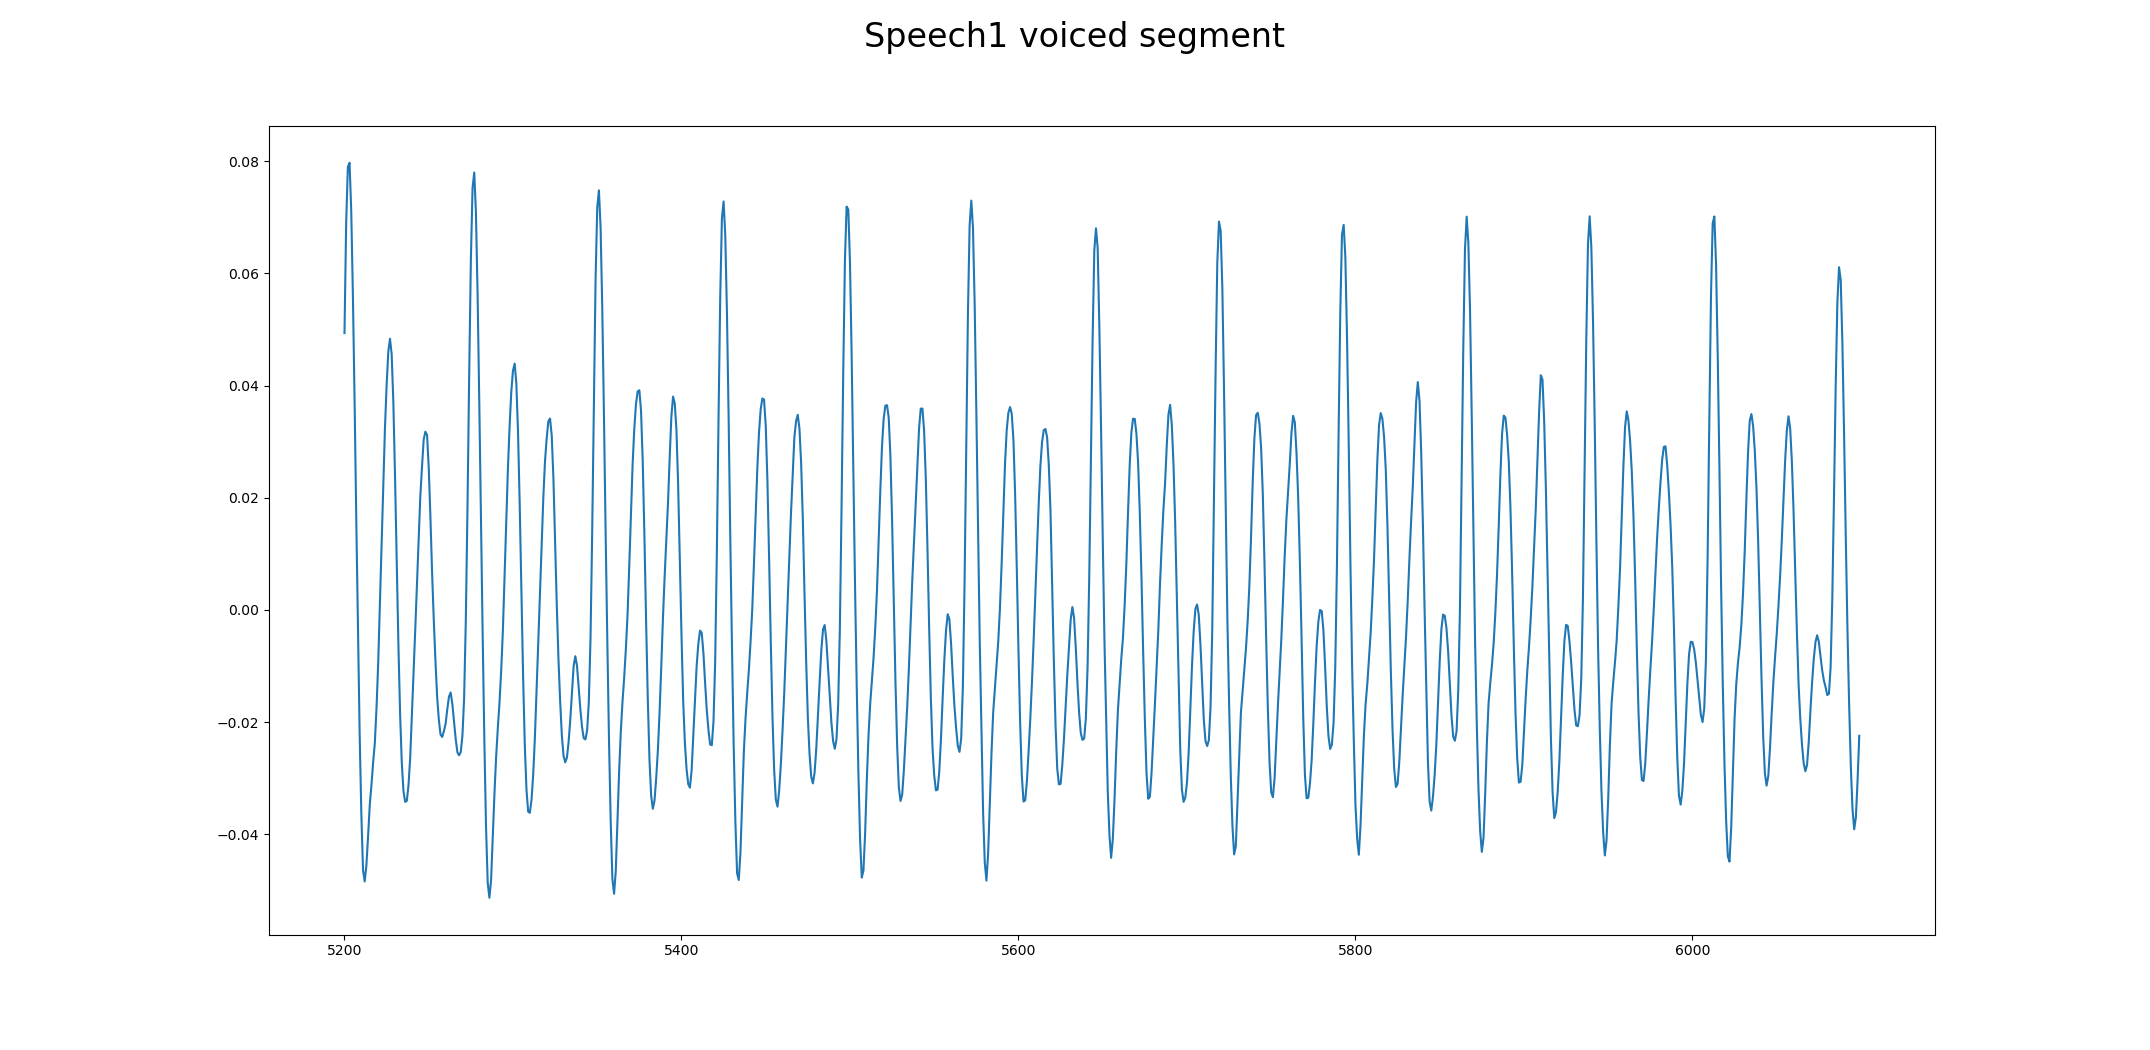

In [158]:
%matplotlib widget
fig = plt.gcf()
fig.set_size_inches(21.5, 10.5)
x1_voiced = x1[5200:6100]
plt.suptitle("Speech1 voiced segment", fontsize=24)
plt.plot(x1_voiced, speech1_data[5200:6100])

In [159]:
def estimate_fundamental_frequency(segment, threshold):
    filtered = np.where(segment > threshold)[0]
    acc = 0.0
    count = 0.0
    for i in range(len(filtered) - 1):
        diff = abs(filtered[i+1] - filtered[i])
        if diff > 1:
            acc = acc + diff
            count = count + 1
    avg_dist = acc/count
    print('Average distance between peaks: ',avg_dist)
    fund_freq = sample_rate/avg_dist
    return fund_freq

In [160]:
fund_freq_est1 = np.floor(estimate_fundamental_frequency(speech1_data[5200:6200], 0.06))
print(f'The estimated fundamental frequency of speech1 is: {fund_freq_est1:n}Hz.\n'
      f'Since female voice fundamental frequency is typically in the range between 160-300Hz, this is most likely a female voice.')


Average distance between peaks:  71.61538461538461
The estimated fundamental frequency of speech1 is: 223Hz.
Since female voice fundamental frequency is typically in the range between 160-300Hz, this is most likely a female voice.


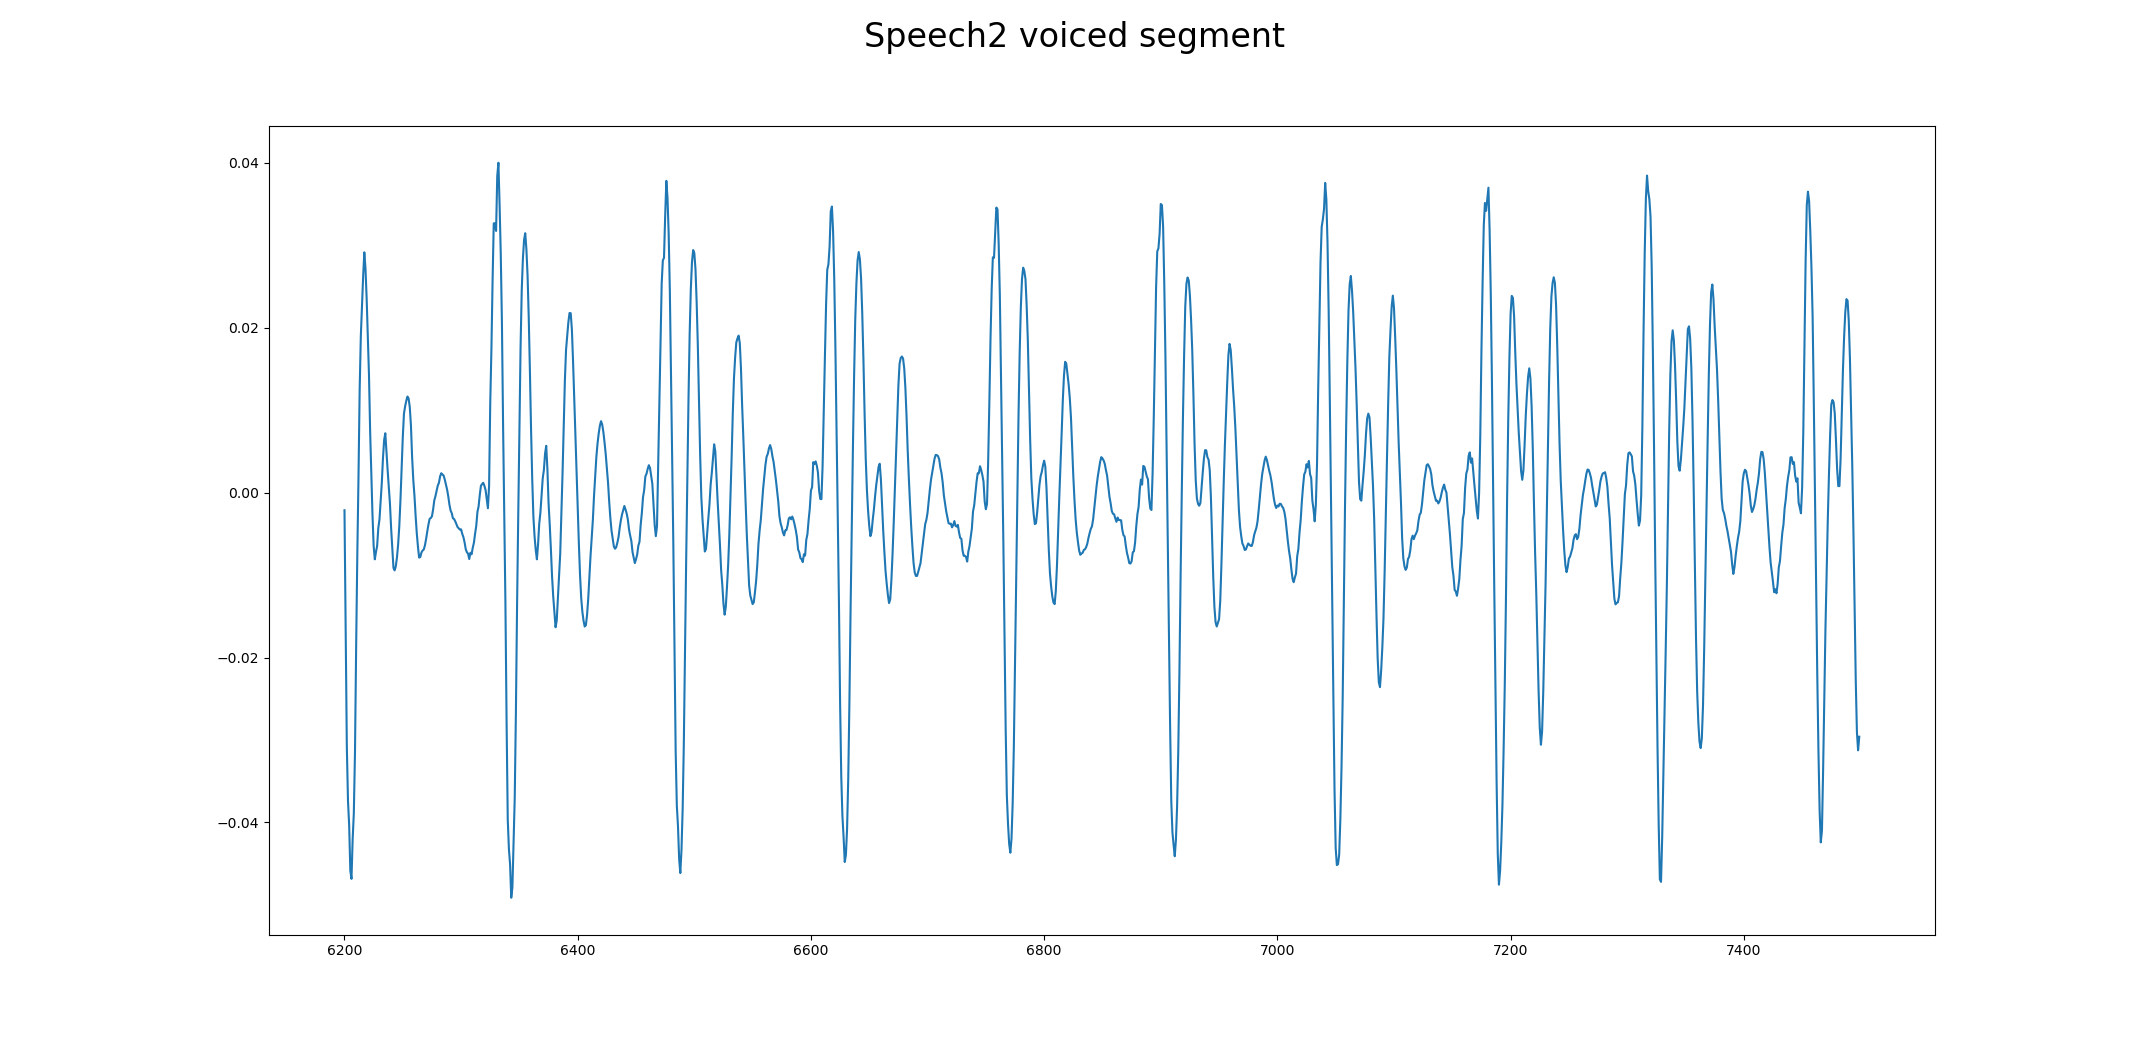

In [161]:
%matplotlib widget
fig = plt.gcf()
fig.set_size_inches(21.5, 10.5)
x2_voiced = x2[6200:7500]
plt.suptitle("Speech2 voiced segment", fontsize=24)
plt.plot(x2_voiced, speech2_data[6200:7500])

In [162]:
fund_freq_est2 = np.floor(estimate_fundamental_frequency(speech2_data[6200:7500], 0.034))
print(f'The estimated fundamental frequency of speech1 is: {fund_freq_est2:n}Hz.\n'
      f'Since male voice fundamental frequency is typically in the range between 60-180Hz, this is most likely a male voice.')

Average distance between peaks:  138.625
The estimated fundamental frequency of speech1 is: 115Hz.
Since male voice fundamental frequency is typically in the range between 60-180Hz, this is most likely a male voice.


In [163]:
def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length: int, frame_shift: int) -> [np.ndarray, np.ndarray]:
    millis_per_point = 1000 / sampling_rate
    frame_length_num_points = frame_length / millis_per_point
    frame_shift_num_points = frame_shift / millis_per_point
    num_frames = int(np.floor((len(v_signal) - frame_length_num_points) / frame_shift_num_points) + 1)
    m_frames = np.zeros((num_frames, int(frame_length_num_points)))
    v_time_frame = np.zeros(num_frames)
    for i in range(num_frames):
        start = int(i * frame_shift_num_points)
        end = int(i * frame_shift_num_points + frame_length_num_points)
        m_frames[i] = v_signal[start:end]
        v_time_frame[i] = (start + end)/(2*sampling_rate)
    return [m_frames, v_time_frame]

In [164]:
frame_length = 32
frame_shift = 16
[frames1, centers1] = my_windowing(speech1_data, sample_rate, frame_length, frame_shift)
[frames2, centers2] = my_windowing(speech2_data, sample_rate, frame_length, frame_shift)

In [165]:
frames1.shape

(176, 512)

In [166]:
frames2.shape

(177, 512)

In [167]:
def auto_correlation(frames):
    acf = np.convolve(frames[0], np.flip(frames[0]))
    acf_size = acf.shape[0]
    acfs = np.zeros((frames.shape[0], acf_size))
    for i in range(frames.shape[0]):
        acfs[i] = np.convolve(frames[i], np.flip(frames[i]))

    return acfs

In [168]:
#acf = np.convolve(frames[0], np.flip(frames[0]))
#acf_size = acf.shape[0]

In [169]:
#acfs = np.zeros((frames.shape[0], acf_size))
#
#
#for i in range(frames.shape[0]):
#    acfs[i] = np.convolve(frames[i], np.flip(frames[i]))
#
#acfs.shape

In [170]:
acfs1 = auto_correlation(frames1)
acfs2 = auto_correlation(frames2)

In [171]:
def remove_negatives(acfs):
    acfs_positive = np.zeros((acfs.shape[0], int(acfs.shape[1]/2)+1))
    for i in range(acfs.shape[0]):
        acfs_positive[i] = acfs[i][int(acfs.shape[1]/2):acfs.shape[1]]
    return acfs_positive

In [172]:
#acfs_positive = np.zeros((acfs.shape[0], int(acfs.shape[1]/2)+1))
#for i in range(acfs.shape[0]):
#    acfs_positive[i] = acfs[i][int(acfs.shape[1]/2):acfs.shape[1]]

In [173]:
acfs_positive1 = remove_negatives(acfs1)
acfs_positive2 = remove_negatives(acfs2)

In [174]:
def calc_fundamental_freqs(acfs_positive):
    search_range_min = int(16000/400)
    search_range_max = int(16000/80)

    fundamental_freqs = np.zeros(acfs_positive.shape[0])
    for i in range(acfs_positive.shape[0]):
        acf_range = acfs_positive[i][search_range_min: search_range_max+1]
        sample_idx = acf_range.argmax() + search_range_min
        millis = sample_idx / 16000
        fundamental_freqs[i] = 1 / millis
    return fundamental_freqs

In [175]:
#search_range_min = int(16000/400)
#search_range_max = int(16000/80)
#
#fundamental_freqs = np.zeros(acfs_positive.shape[0])
#for i in range(acfs_positive.shape[0]):
#    acf_range = acfs_positive[i][search_range_min: search_range_max+1]
#    sample_idx = acf_range.argmax() + search_range_min
#    millis = sample_idx / 16000
#    fundamental_freqs[i] = 1 / millis
#
#fundamental_freqs

In [176]:
fundamental_freqs1 = calc_fundamental_freqs(acfs_positive1)
fundamental_freqs2 = calc_fundamental_freqs(acfs_positive2)

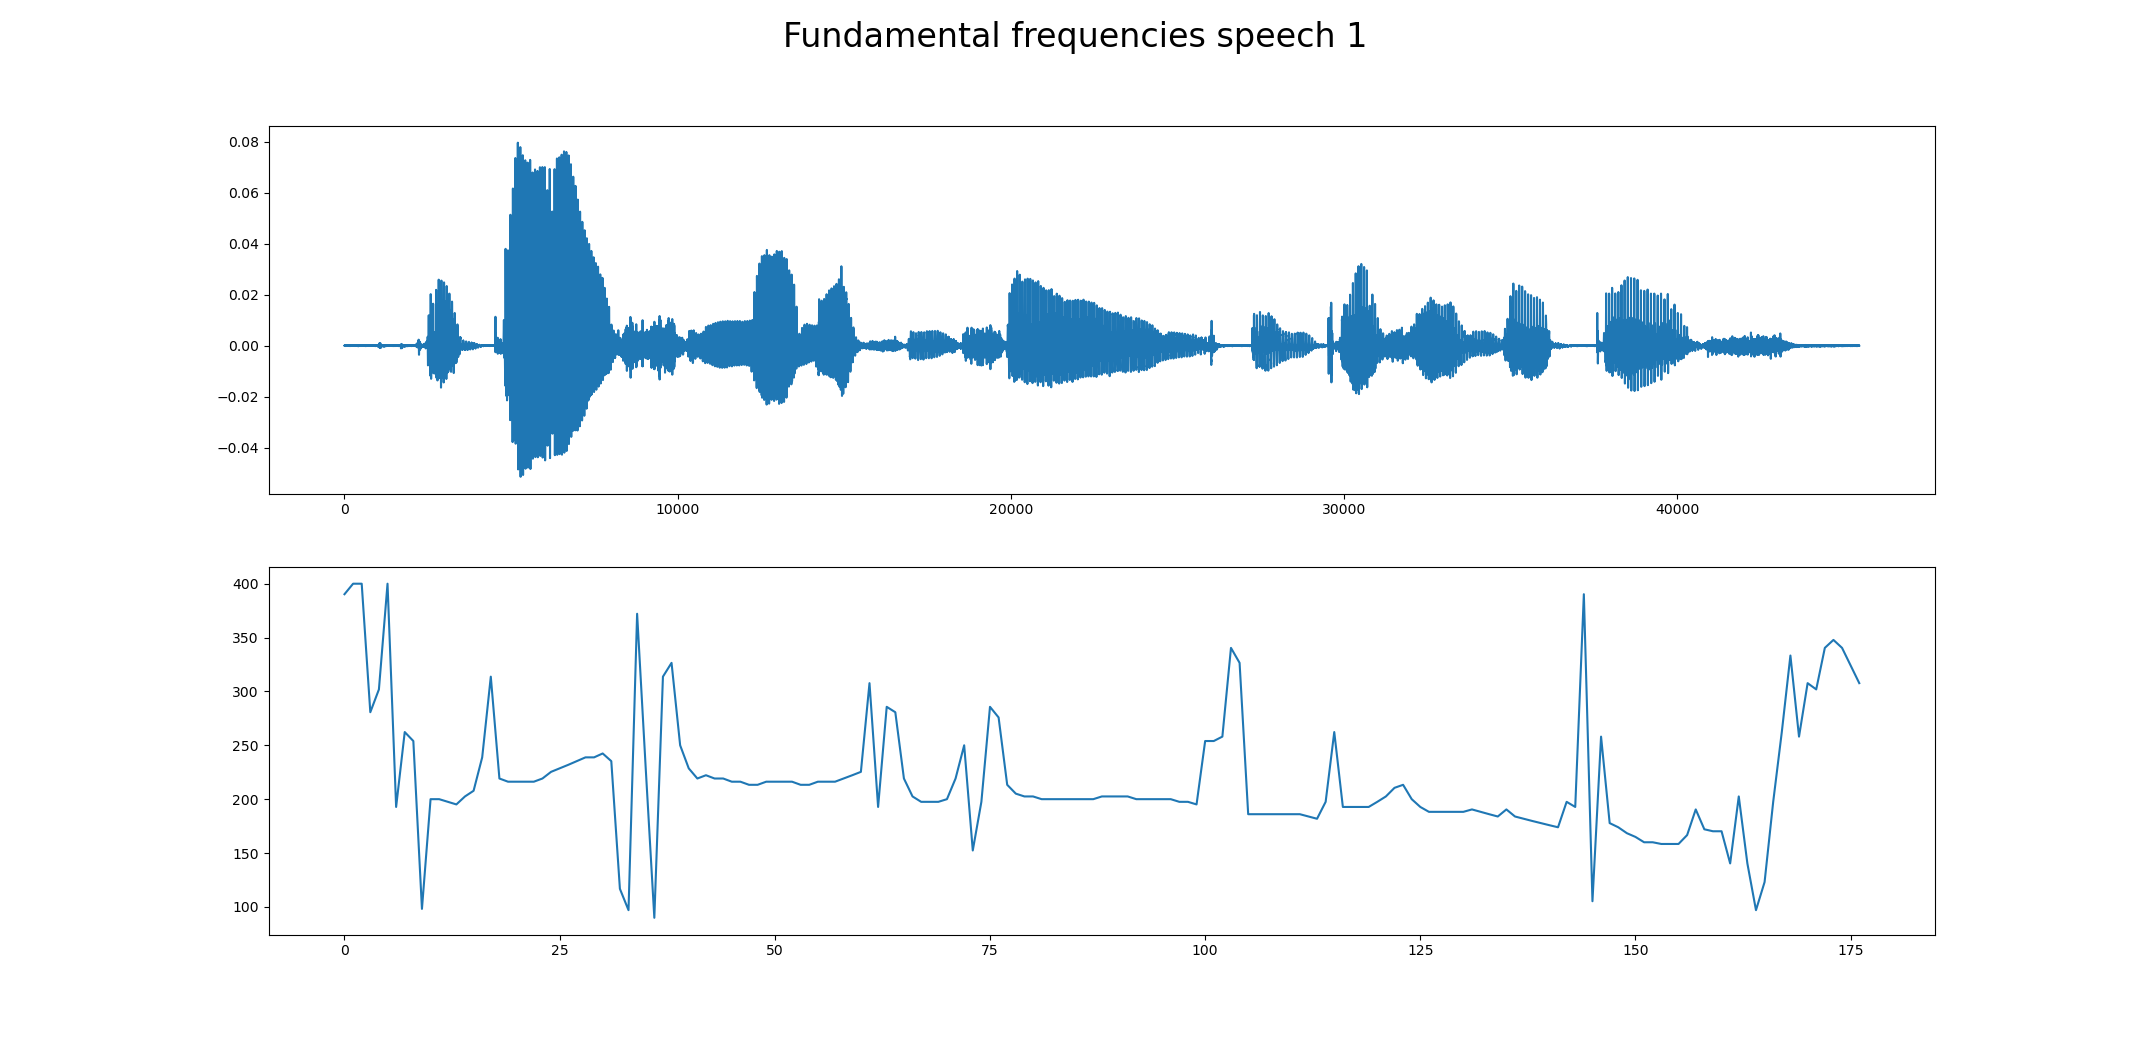

In [177]:
%matplotlib widget
fig, axs = plt.subplots(2)
fig.set_size_inches(21.5, 10.5)
fig.suptitle("Fundamental frequencies speech 1", fontsize=24)
axs[0].plot(x1, speech1_data)
axs[1].plot(np.linspace(0, fundamental_freqs1.shape[0], num=fundamental_freqs1.shape[0], dtype=np.int32), fundamental_freqs1)

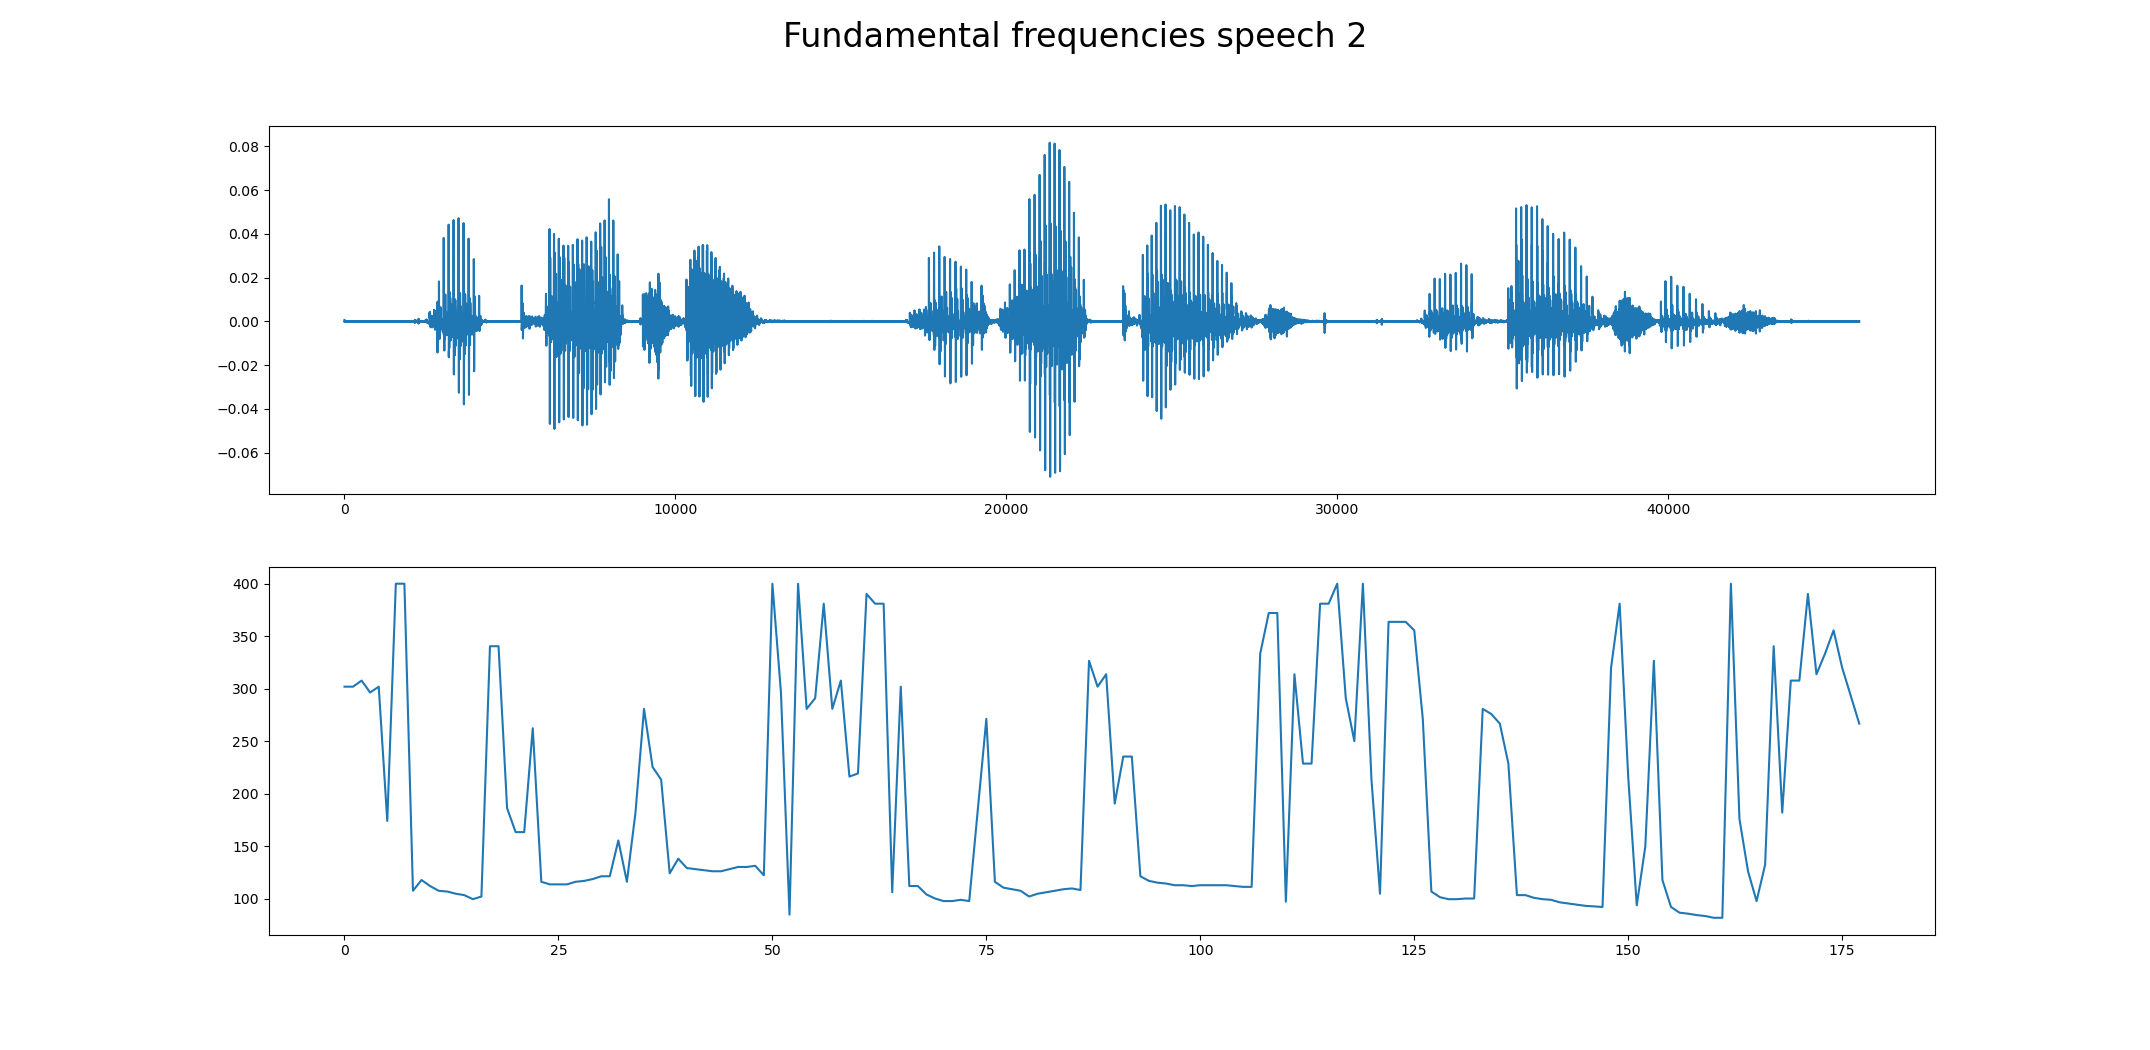

In [178]:
%matplotlib widget
fig, axs = plt.subplots(2)
fig.set_size_inches(21.5, 10.5)
fig.suptitle("Fundamental frequencies speech 2", fontsize=24)
axs[0].plot(x2, speech2_data)
axs[1].plot(np.linspace(0, fundamental_freqs2.shape[0], num=fundamental_freqs2.shape[0], dtype=np.int32), fundamental_freqs2)